# От дерева решений к ансамблю и кластеризации

## Цель проекта

Закрепить понимание принципов работы алгоритмов деревьев решений, ансамблей и кластеризации через собственную реализацию и анализ их поведения на данных.

В ходе проекта:
- реализованы базовые версии алгоритмов с нуля, используя `numpy` и `pandas`;
- проведены эксперименты с параметрами и сравнением результатов с реализациями из `sklearn`;
- описаны и визуализированы результаты.

## Структура проекта

1. **Дерево решений для классификации**
- реализация критерия Джини / энтропии;
- поиск оптимального разбиения и рекурсивное построение дерева;
- предсказания для новых наблюдений и сравнение с `sklearn.DecisionTreeClassifier`.

2. **Ансамбль на основе бэггинга**
- построение нескольких деревьев на bootstrap-выборках;
- агрегирование предсказаний (голосование / усреднение);
- сравнение устойчивости и качества с одиночным деревом.

3. **Кластеризация методом k-means**
- реализация k-means "вручную";
- масштабирование признаков и понижение размерности с помощью PCA;
- визуализация кластеров в 2D и сравнение результатов со `sklearn.KMeans`.

4. **Подведены итоги и сделан общий вывод**
- как устроены алгоритмы;
- чем они отличаются друг от друга;
- как их параметры влияют на качество и устойчивость моделей.

### Этап 1. Подготовка данных для дерева решений:

1. Генерируем синтетический набор данных для задачи классификации.
2. Упаковываем его в pandas.DataFrame для удобного анализа и визуализаций.
3. Реализуем функции:
    - расчета критерия Джини или энтропии;
    - поиска наилучшего разбиения по признаку;
    - рекурсивного построения дерева с ограничениями;
    - предсказания для новых наблюдений.
4. Тестируем модели.
5. Подводим итоги.

In [216]:
# Импортируем необходимые библиотеки
import pandas as pd
from sklearn.datasets import make_classification

In [217]:
# 1.1. Генерация синтетического датасета

# n_samples=200 — количество наблюдений (объектов);
# n_features=2 — два признака, чтобы удобно рисовать границы решений в 2D;
# n_informative=2 — оба признака информативны (важны для разделения классов);
# n_redundant=0 — нет лишних линейных комбинаций информативных признаков;
# random_state=42 — фиксируем генератор случайных чисел для воспроизводимости.
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    random_state=42
)

# Проверим размерности массивов (строки -> объекты, столбцы -> признаки)
print("Форма X:", X.shape)
print("Форма y:", y.shape)

Форма X: (200, 2)
Форма y: (200,)


In [218]:
# 1.2. Преобразование в pandas.DataFrame

# Создаем таблицу с понятными названиями признаков.
df = pd.DataFrame(X, columns=["feature_1", "feature_2"])
# Добавляем столбец с целевой переменной (классом)
df["target"] = y

# Быстрый просмотр первых и последних строк таблицы,
# чтобы убедиться, что данные выглядят адекватно.
display(df)

,feature_1,feature_2,target
0,1.689767,-1.408241,1
1,1.530287,-1.459848,1
2,-1.175042,-1.447633,0
3,-2.585395,0.963532,0
4,1.372246,0.440695,1
...,...,...,...
195,-0.435396,0.715716,0
196,1.040417,1.108613,1
197,1.883798,0.782433,0
198,1.829367,1.542978,1


In [219]:
"""
1.3. Структура узла дерева решений.

В этой ячейке описан минимальный строительный блок дерева,
узел, который может быть:
    - внутренним (хранит признак, порог и ссылки на потомков);
    - листом (хранит только предсказываемый класс).
"""

from dataclasses import dataclass
from typing import Any, Optional


# Используем для удобства декоратор @dataclass,
# который автоматически создает конструктор и repr для узла дерева
@dataclass
class DecisionTreeNode:
    """
    Узел дерева решений.

    feature_index: Optional[int]
        Индекс признака, по которому выполняется разбиение.
        Если None, узел является листом.
    threshold: Optional[float]
        Порог разбиения для числового признака.
        Левая ветвь: x[feature_index] <= threshold,
        правая ветвь: x[feature_index] > threshold.
    left: Optional["DecisionTreeNode"]
        Левый дочерний узел.
    right: Optional["DecisionTreeNode"]
        Правый дочерний узел.
    value: Optional[Any]
        Значение класса для листа. Для внутренних узлов value = None.
    """
    feature_index: Optional[int] = None
    threshold: Optional[float] = None
    left: Optional["DecisionTreeNode"] = None
    right: Optional["DecisionTreeNode"] = None
    value: Optional[Any] = None


In [220]:
"""
1.3.1. Функции оценки неоднородности узла:
    - критерий Джини,
    - энтропия Шеннона.

Оба критерия возвращают одно число (float), показывающее,
насколько "грязный" узел (смешанные классы).
"""

import numpy as np


def gini_impurity(y: np.ndarray) -> float:
    """
    Вычисляет критерий Джини.

    Назначение:
        Показывает степень неоднородности выборки.
        0.0 —> идеальная чистота (все объекты одного класса),
        максимум для двух классов —> 0.5 (пропорция 50/50).

    Параметры:
        y: np.ndarray
            Метки классов в рассматриваемом узле.

    Возвращает:
        float
            Значение критерия Джини.

    Пример:
        gini_impurity([0, 0, 1])
        0.444...
    """
    y = np.asarray(y)
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return 1 - np.sum(probabilities ** 2)


def entropy_impurity(y: np.ndarray) -> float:
    """
    Вычисляет энтропию Шеннона.

    Назначение:
        Оценивает степень неопределенности.
        0.0 —> чистый узел, максимум —> 1.0 для двух классов 50/50.

    Параметры:
        y: np.ndarray
            Метки классов.

    Возвращает:
        float
            Значение энтропии.

    Пример:
        entropy_impurity([0, 1])
        1.0
    """
    y = np.asarray(y)
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()

    mask = probabilities > 0
    probabilities = probabilities[mask]

    return -np.sum(probabilities * np.log2(probabilities))


In [221]:
"""
1.3.1. Выбор критерия и класс большинства

Функции-утилиты:
    - выбор критерия gini/entropy,
    - вычисление наиболее частого класса (majority vote).
"""

from typing import Literal, Any


def impurity(y: np.ndarray, criterion: Literal["gini", "entropy"]) -> float:
    """
    Выбирает и вычисляет критерий неоднородности.

    Параметры:
        y: np.ndarray
            Метки классов.
        criterion: {"gini", "entropy"}
            Выбранный критерий.

    Возвращает:
        float
            Значение критерия.
    """
    if criterion == "gini":
        return gini_impurity(y)
    elif criterion == "entropy":
        return entropy_impurity(y)
    else:
        raise ValueError(f"Неизвестный критерий: {criterion}")


def majority_vote(y: np.ndarray) -> Any:
    """
    Вычисляет наиболее часто встречающийся класс.

    При равенстве частот берется класс с минимальным значением.

    Параметры:
        y: np.ndarray
            Вектор классов.

    Возвращает:
        label: Any
            Класс большинства.
    """
    y = np.asarray(y)
    classes, counts = np.unique(y, return_counts=True)
    return classes[np.argmax(counts)]


In [222]:
"""
1.3.2. Функция поиска оптимального разбиения узла:
    - перебирает признаки,
    - перебирает пороги,
    - ищет максимальный прирост качества (information gain).
"""

from typing import Optional, Tuple


def find_best_split(
        X: np.ndarray,
        y: np.ndarray,
        criterion: Literal["gini", "entropy"] = "gini",
) -> Tuple[Optional[int], Optional[float], float]:
    """
    Ищет оптимальный признак и порог для разбиения узла.

    Алгоритм:
        1. Для каждого признака сортируем значения.
        2. Проходим по всем возможным порогам между уникальными значениями.
        3. Для каждого порога вычисляем прирост качества.
        4. Возвращаем лучший признак, порог и gain.

    ВОзвращает:
        best_feature : Optional[int]
        best_threshold : Optional[float]
        best_gain : float

    Если gain = 0 и разбиение не улучшает ситуацию —> возвращаем None, None, 0.0.
    """
    X = np.asarray(X)
    y = np.asarray(y)

    n_samples, n_features = X.shape
    if n_samples <= 1:
        return None, None, 0.0

    parent_imp = impurity(y, criterion)

    best_gain = 0.0
    best_feature = None
    best_threshold = None

    # Перебираем признаки
    for feature_idx in range(n_features):
        values = X[:, feature_idx]

        sorted_idx = np.argsort(values)
        sorted_values = values[sorted_idx]
        sorted_y = y[sorted_idx]

        if np.unique(sorted_values).size == 1:
            continue

        for i in range(1, n_samples):
            if sorted_values[i] == sorted_values[i - 1]:
                continue

            threshold = (sorted_values[i] + sorted_values[i - 1]) / 2

            left_mask = sorted_values <= threshold
            right_mask = ~left_mask

            y_left = sorted_y[left_mask]
            y_right = sorted_y[right_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            left_imp = impurity(y_left, criterion)
            right_imp = impurity(y_right, criterion)

            weighted = (len(y_left) * left_imp + len(y_right) * right_imp) / n_samples
            gain = parent_imp - weighted

            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = threshold

    return best_feature, best_threshold, best_gain


In [223]:
"""
1.3.3. Рекурсивная функция build_tree:
    - проверяет стоп-условия,
    - вызывает find_best_split,
    - создает детей и продолжает построение.
"""


def build_tree(
        X: np.ndarray,
        y: np.ndarray,
        depth: int,
        max_depth: Optional[int],
        min_samples_split: int,
        criterion: Literal["gini", "entropy"],
) -> DecisionTreeNode:
    """
    Рекурсивно строит дерево решений.

    Стоп-условия:
        1. Все объекты одного класса.
        2. Достигнута максимальная глубина.
        3. Размер узла меньше минимального количества объектов.
        4. Нет улучшения качества при разбиении.

    Возвращает:
        DecisionTreeNode
            Узел дерева (внутренний или лист).
    """
    X = np.asarray(X)
    y = np.asarray(y)

    num_samples, _ = X.shape

    unique_classes = np.unique(y)
    if len(unique_classes) == 1:
        return DecisionTreeNode(value=unique_classes[0])

    if max_depth is not None and depth >= max_depth:
        return DecisionTreeNode(value=majority_vote(y))

    if num_samples < min_samples_split:
        return DecisionTreeNode(value=majority_vote(y))

    feature, threshold, gain = find_best_split(X, y, criterion)

    if feature is None or gain <= 0:
        return DecisionTreeNode(value=majority_vote(y))

    left_mask = X[:, feature] <= threshold
    right_mask = ~left_mask

    if sum(left_mask) == 0 or sum(right_mask) == 0:
        return DecisionTreeNode(value=majority_vote(y))

    left_child = build_tree(
        X[left_mask], y[left_mask],
        depth + 1, max_depth, min_samples_split, criterion
    )
    right_child = build_tree(
        X[right_mask], y[right_mask],
        depth + 1, max_depth, min_samples_split, criterion
    )

    return DecisionTreeNode(
        feature_index=feature,
        threshold=threshold,
        left=left_child,
        right=right_child,
        value=None,
    )


In [224]:
"""
1.3.4. Функция предсказания для одного объекта.
Проходит путь от корня к листу.
"""


def predict_single(x: np.ndarray, node: DecisionTreeNode):
    """
    Предсказывает класс одного объекта.

    Параметры:
        x: np.ndarray
            Вектор признаков.
        node: DecisionTreeNode
            Текущий узел.

    Возвращает:
        predict_single: единственный класс (label) для объекта x
    """
    if node.feature_index is None or node.threshold is None:
        return node.value

    if x[node.feature_index] <= node.threshold:
        return predict_single(x, node.left)
    else:
        return predict_single(x, node.right)


In [225]:
"""
1.3.4. Класс-обертка над деревом.

Использует:
    - build_tree для обучения,
    - predict_single для предсказания,
    - параметры max_depth, min_samples_split, criterion.
"""

from typing import Optional


class DecisionTreeClassifierCustom:
    """
    Реализация классификатора на основе дерева решений.

    Алгоритм:
        - Ручная реализация критериев Джини / энтропии.
        - Полный перебор порогов и признаков.
        - Рекурсивное построение дерева.
        - Поддержка max_depth и min_samples_split.
    """

    def __init__(
            self,
            max_depth: Optional[int] = None,
            min_samples_split: int = 2,
            criterion: Literal["gini", "entropy"] = "gini",
            random_state: Optional[int] = None,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.random_state = random_state

        self.root_: Optional[DecisionTreeNode] = None
        self.classes_: Optional[np.ndarray] = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Обучает дерево на данных.

        Параметры:
            X: np.ndarray
            y: np.ndarray

        Возвращает:
            self
        """
        X = np.asarray(X)
        y = np.asarray(y)

        self.classes_ = np.unique(y)

        self.root_ = build_tree(
            X=X,
            y=y,
            depth=0,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            criterion=self.criterion,
        )
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает классы объектов массива X.

        Возвращает:
            np.ndarray
        """
        if self.root_ is None:
            raise RuntimeError("Сначала вызовите fit().")

        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        return np.array([predict_single(x, self.root_) for x in X])


In [226]:
"""
1.4. Тестирование модели: шаг 1.

Разделяем данные на обучающую и тестовую выборки.

Важно:
    - фиксируем random_state=42 для воспроизводимости;
    - используем stratify=y, чтобы пропорции классов в train и test совпадали.
"""

from sklearn.model_selection import train_test_split

# Выделяем признаки (X) и целевую переменную (y) из DataFrame
X = df[["feature_1", "feature_2"]].values
y = df["target"].values

# Делим датасет на обучающую и тестовую части
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    # 30% данных уйдет в тест
    test_size=0.3,
    # фиксируем разбиение
    random_state=42,
    # сохраняем пропорции классов
    stratify=y
)

print("Размер обучающей выборки:", X_train.shape, y_train.shape)
print("Размер тестовой выборки:", X_test.shape, y_test.shape)


Размер обучающей выборки: (140, 2) (140,)
Размер тестовой выборки: (60, 2) (60,)


In [227]:
"""
1.4. Тестирование модели: шаг 2.

Обучаем реализацию дерева решений и оцениваем качество
на обучающей и тестовой выборках.
"""

from sklearn.metrics import accuracy_score

# Создаем экземпляр дерева решений
custom_tree = DecisionTreeClassifierCustom(
    # ограничиваем глубину для наглядности
    max_depth=4,
    min_samples_split=2,
    criterion="gini",
    random_state=42
)

# Обучаем модель на тренировочных данных
custom_tree.fit(X_train, y_train)

# Предсказываем классы на train и test
y_train_pred_custom = custom_tree.predict(X_train)
y_test_pred_custom = custom_tree.predict(X_test)

# Считаем accuracy для обучения и теста
train_acc_custom = accuracy_score(y_train, y_train_pred_custom)
test_acc_custom = accuracy_score(y_test, y_test_pred_custom)

print(f"Кастомное дерево -> точность (train): {train_acc_custom:.3f}")
print(f"Кастомное дерево -> точность (test): {test_acc_custom:.3f}")


Кастомное дерево -> точность (train): 0.936
Кастомное дерево -> точность (test): 0.850


In [228]:
"""
1.4. Тестирование модели: шаг 3.

Обучаем DecisionTreeClassifier из sklearn с теми же параметрами
и сравниваем качество. Используем его только для проверки
корректности собственной реализации.
"""

from sklearn.tree import DecisionTreeClassifier

# Дерево из sklearn с теми же гиперпараметрами
sklearn_tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=2,
    criterion="gini",
    random_state=42
)

sklearn_tree.fit(X_train, y_train)

y_train_pred_sklearn = sklearn_tree.predict(X_train)
y_test_pred_sklearn = sklearn_tree.predict(X_test)

train_acc_sklearn = accuracy_score(y_train, y_train_pred_sklearn)
test_acc_sklearn = accuracy_score(y_test, y_test_pred_sklearn)

print(f"Дерево sklearn -> точность (train): {train_acc_sklearn:.3f}")
print(f"Дерево sklearn -> точность (test): {test_acc_sklearn:.3f}")


Дерево sklearn -> точность (train): 0.936
Дерево sklearn -> точность (test): 0.850


In [229]:
"""
1.4. Тестирование модели: шаг 4.

Сводим результаты в одну таблицу для удобного сравнения.
"""

results_df = pd.DataFrame(
    {
        "model": [
            "Custom Decision Tree",
            "sklearn DecisionTreeClassifier",
        ],
        "train_accuracy": [
            train_acc_custom,
            train_acc_sklearn,
        ],
        "test_accuracy": [
            test_acc_custom,
            test_acc_sklearn,
        ],
    }
)

results_df


,model,train_accuracy,test_accuracy
0,Custom Decision Tree,0.935714,0.85
1,sklearn DecisionTreeClassifier,0.935714,0.85


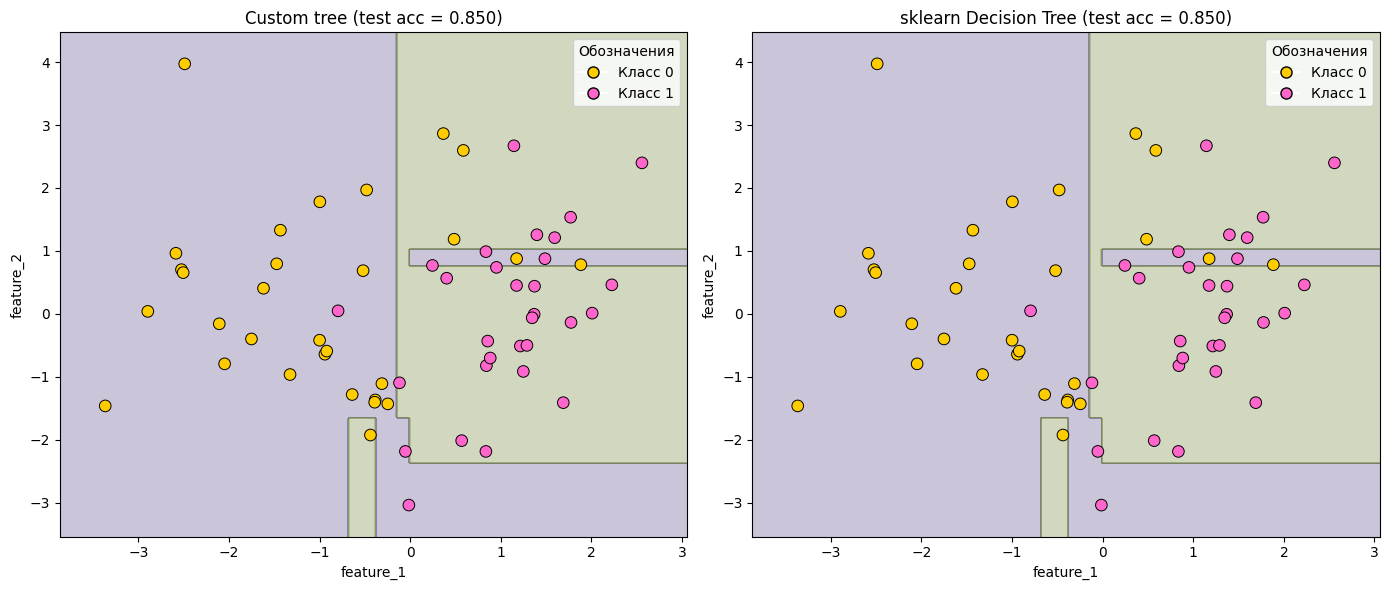

In [230]:
"""
1.4. Тестирование модели: шаг 5.

Строим графики границ решений для собственной реализации и для sklearn.
"""

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_decision_boundaries(model, X, y, ax, title: str) -> None:
    """
    Рисует границы решений и реальные точки данных для двумерной задачи классификации.

    Параметры:
        model:
            Обученная модель с методом predict(X).
        X: np.ndarray, shape (n_samples, 2)
            Матрица признаков.
        y: np.ndarray, shape (n_samples,)
            Истинные метки классов.
        ax: matplotlib.axes.Axes
            Ось для построения графика.
        title: str
            Заголовок графика.
    """

    # Цвета фона (области решений)
    cmap_background = ListedColormap(["#504080", "#6a8030"])
    # Цвета точек (реальные наблюдения)
    cmap_points = ListedColormap(["#ffcc00", "#ff66cc"])

    # Диапазоны осей
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Сетка точек
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Предсказания модели на сетке
    Z = model.predict(grid).reshape(xx.shape)

    # Области решений
    ax.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)

    # Точки тестовой выборки
    scatter = ax.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap=cmap_points,
        edgecolor="black",
        linewidth=0.7,
        s=70,
        label="Точки выборки"
    )

    # Подписи и оформление
    ax.set_title(title, fontsize=12)
    # Имена двух признаков
    ax.set_xlabel("feature_1")
    ax.set_ylabel("feature_2")

    # Формируем легенду по уникальным классам
    handles = []
    labels = []
    unique_classes = np.unique(y)
    for cls in unique_classes:
        handles.append(
            plt.Line2D(
                [], [],
                marker='o',
                color='w',
                markerfacecolor=cmap_points(cls),
                markeredgecolor='k',
                markersize=8
            )
        )
        labels.append(f"Класс {cls}")

    ax.legend(handles, labels, title="Обозначения", loc="upper right")


# Построение двух графиков: custom и sklearn
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_decision_boundaries(
    model=custom_tree,
    X=X_test,
    y=y_test,
    ax=axes[0],
    title=f"Custom tree (test acc = {test_acc_custom:.3f})",
)

plot_decision_boundaries(
    model=sklearn_tree,
    X=X_test,
    y=y_test,
    ax=axes[1],
    title=f"sklearn Decision Tree (test acc = {test_acc_sklearn:.3f})",
)

plt.tight_layout()
plt.show()


### Сравнение собственной реализации и `sklearn.DecisionTreeClassifier`

По итогам эксперимента:

- **Точность на обучении и тесте у моделей совпадает**:
  `Custom Decision Tree` и `sklearn DecisionTreeClassifier` показали одинаковые значения `train_accuracy` и `test_accuracy`.
- **Границы решений на графиках визуально очень похожи, но не идентичны по деталям**:
    - общая форма областей почти совпадает;
    - различия видны в мелких "ступеньках" и точном положении границ.

Основные причины отличий:

1. **Оптимизация и численные нюансы**
- В собственной реализации я перебираю все пороги простым циклом по отсортированным значениям.
- В `sklearn` используются оптимизированные алгоритмы, которые могут по-другому обрабатывать граничные случаи и числовую точность.

2. **Набор стоп-критериев и детализация параметров**
- В моем дереве используются только `max_depth` и `min_samples_split`.
- В `sklearn` реализовано больше механизмов контроля сложности (например, `min_samples_leaf`, `min_impurity_decrease`), что влияет на форму финального дерева, даже при одинаковых основных параметрах.


**Вывод:**

Собственная реализация корректно воспроизводит поведение дерева решений на уровне качества и формы границ решений, но остается менее оптимизированной версией по сравнению с `sklearn`.

### Этап 2. Построение ансамбля деревьев (бэггинг):

1. Разрабатываем функцию для bootstrap-выборки:
- случайный выбор объектов с возвращением;
- размер выборки равен исходной обучающей выборке.

2. Реализуем обучение одного дерева на bootstrap-подвыборке:
- создаем копию собственной модели DecisionTreeClassifierCustom;
- обучаем ее на bootstrap-данных;
- сохраняем обученное дерево в список ансамбля.

3. Повторяем процесс N раз для формирования ансамбля:
- N in {5, 10, 20} или другие значения;
- фиксируем random_state для воспроизводимости.

4. Реализуем функцию агрегирования предсказаний:
- собираем предсказания всех деревьев;
- объединяем через голосование (majority vote);
- при желании реализуем усреднение вероятностей.

5. Сравниваем качество:
- качество одного дерева vs ансамбль из N деревьев;
- собираем результаты в таблицу для разных N.

6. Строим график зависимости точности от количества деревьев:
- визуализируем, как растет устойчивость и точность модели.

7. Формулируем вывод:
- как бэггинг влияет на качество;
- почему ансамбль устойчивее одиночного дерева;
- поведение модели при росте числа деревьев.

In [231]:
"""
Этап 2.1. Реализация функции bootstrap-выборки.

Логика:
    Формируем новый набор данных такого же размера, как обучающая выборка,
    случайно выбирая объекты с возвращением.
    То есть один и тот же объект может попасть в выборку несколько раз.

Цель:
    Бэггинг создает несколько альтернативных обучающих подвыборок, каждая из которых
    порождает свое дерево решений. Разнообразие подвыборок снижает дисперсию модели
    и делает ансамбль устойчивее.

Функция ниже:
    - принимает X и y исходной обучающей выборки,
    - выбирает bootstrap-индексы,
    - возвращает X_bootstrap, y_bootstrap.
"""


def bootstrap_sample(
        X: np.ndarray,
        y: np.ndarray,
        random_state: int | None = None
) -> tuple[np.ndarray, np.ndarray]:
    """
    Создает bootstrap-подвыборку из обучающих данных.

    Параметры:
        X: np.ndarray, shape (n_samples, n_features)
            Исходная матрица признаков.
        y: np.ndarray, shape (n_samples,)
            Исходный вектор меток классов.
        random_state: int or None
            Фиксируем seed для воспроизводимости.

    Возвращает:
        X_boot: np.ndarray
            Матрица признаков bootstrap-подвыборки.
        y_boot: np.ndarray
            Метки классов bootstrap-подвыборки.

    Примечание:
        - выбор происходит с возвращением;
        - размер bootstrap-выборки равен исходному;
        - используется генератор numpy RandomState.
    """
    rng = np.random.default_rng(random_state)

    n_samples = X.shape[0]

    # Берем случайные индексы с возвращением
    indices = rng.integers(0, n_samples, size=n_samples)

    X_boot = X[indices]
    y_boot = y[indices]

    return X_boot, y_boot


In [232]:
"""
Этап 2.2. Обучение одного дерева на bootstrap-подвыборке.

Цель:
    - Сформировать bootstrap-подвыборку из обучающих данных (с возвращением).
    - Обучить на ней собственное дерево решений DecisionTreeClassifierCustom.
    - Вернуть обученную модель, которую можно добавить в ансамбль.

Вспомогательна функция для:
    - удобства использования в цикле (при построении ансамбля из N деревьев);
    - явного разделения шагов: выборка -> обучение -> возврат модели.
"""


def train_tree_on_bootstrap(
        X: np.ndarray,
        y: np.ndarray,
        max_depth: Optional[int] = None,
        min_samples_split: int = 2,
        criterion: str = "gini",
        random_state: Optional[int] = None,
) -> DecisionTreeClassifierCustom:
    """
    Обучает одно дерево решений на bootstrap-подвыборке.

    Параметры:
        X: np.ndarray, shape (n_samples, n_features)
            Исходная обучающая матрица признаков.
        y: np.ndarray, shape (n_samples,)
            Исходный вектор меток классов.
        max_depth: Optional[int], default=None
            Максимальная глубина дерева (как и раньше в собственной реализации).
        min_samples_split: int, default=2
            Минимальное количество объектов в узле для разбиения.
        criterion: {"gini", "entropy"}, default="gini"
            Критерий неоднородности, используемый в дереве.
        random_state: Optional[int], default=None
            Начальное значение генератора случайных чисел:
                - для формирования bootstrap-подвыборки,
                - для инициализации дерева.

    Возвращает:
        tree: DecisionTreeClassifierCustom
            Обученное дерево, готовое к использованию в ансамбле.
    """
    # 1. Формируем bootstrap-подвыборку
    X_boot, y_boot = bootstrap_sample(X, y, random_state=random_state)

    # 2. Создаем и обучаем дерево на этой подвыборке
    tree = DecisionTreeClassifierCustom(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        criterion=criterion,
        random_state=random_state,
    )

    tree.fit(X_boot, y_boot)

    # 3. Возвращаем обученную модель
    return tree


In [233]:
"""
Этап 2.3. Построение ансамбля деревьев (бэггинг).

Логика:
    - принимает обучающие данные X_train, y_train;
    - создает N разных bootstrap-подвыборок;
    - обучает N деревьев (используя train_tree_on_bootstrap);
    - сохраняет каждое дерево в список ансамбля;
    - возвращает список обученных моделей.

Примечание:
    Чтобы ансамбль был воспроизводимым и деревья отличались, внутри цикла
    random_state = base_random_state + i, где i —> номер дерева.
    В каждом случае дерево получает свой собственный, но детерминированный seed.
"""

from typing import List


def build_bagging_ensemble(
        X: np.ndarray,
        y: np.ndarray,
        n_estimators: int = 10,
        max_depth: Optional[int] = None,
        min_samples_split: int = 2,
        criterion: str = "gini",
        base_random_state: int = 42,
) -> List[DecisionTreeClassifierCustom]:
    """
    Строит ансамбль деревьев решений (бэггинг).

    Параметры:
        X: np.ndarray
            Обучающие признаки.
        y: np.ndarray
            Метки классов.
        n_estimators: int, default=10
            Количество деревьев в ансамбле.
        max_depth: Optional[int], default=None
            Максимальная глубина каждого дерева.
        min_samples_split: int, default=2
            Минимальный размер узла для разбиения.
        criterion: {"gini", "entropy"}, default="gini"
            Критерий неоднородности.
        base_random_state: int, default=42
            Базовый seed для воспроизводимости. Для каждого дерева
            используем base_random_state + i.

    Возвращает:
        ensemble: List[DecisionTreeClassifierCustom]
            Список обученных деревьев.
    """
    ensemble = []

    for i in range(n_estimators):
        tree_random_state = base_random_state + i

        tree = train_tree_on_bootstrap(
            X=X,
            y=y,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            criterion=criterion,
            random_state=tree_random_state,
        )

        ensemble.append(tree)

    return ensemble


In [234]:
"""
Этап 2.4. Агрегирование предсказаний ансамбля (бэггинг).

Логика:
    Каждое дерево в ансамбле дает свое предсказание класса.
    Собираем все предсказания и выбираем класс,
    который встречается чаще всего
    (majority vote, то есть "голосование большинством").

В итоге:
    - одиночное дерево -> одно мнение,
    - ансамбль из N деревьев -> N голосов,
      финальный ответ -> решение большинства.
"""


def ensemble_predict_majority_vote(
        ensemble: List[DecisionTreeClassifierCustom],
        X: np.ndarray,
) -> np.ndarray:
    """
    Предсказывает метки классов по ансамблю деревьев (majority vote).

    Параметры:
        ensemble: List[DecisionTreeClassifierCustom]
            Список обученных деревьев (собственный ансамбль).
        X: np.ndarray, shape (n_samples, n_features)
            Матрица признаков для предсказания.

    Возвращает:
        y_pred: np.ndarray, shape (n_samples)
            Вектор финальных предсказаний ансамбля.

    Логика:
        1. Для каждого дерева в ансамбле получаем предсказанный вектор классов.
        2. Формируем матрицу предсказаний формы (n_estimators, n_samples).
        3. По каждому объекту (по столбцам) считаем класс большинства.

    Примечание:
        В случае равенства голосов побеждает класс с меньшим числовым значением.
        Это поведение реализовано через np.unique(..., return_counts=True)
        и np.argmax, аналогично majority_vote.
    """
    X = np.asarray(X)

    if not ensemble:
        raise ValueError("Ансамбль пуст. Обучите деревья.")

    # Получаем предсказания всех деревьев
    all_predictions = []
    for tree in ensemble:
        preds = tree.predict(X)
        all_predictions.append(preds)

    # Матрица предсказаний: (n_estimators, n_samples)
    predictions_matrix = np.vstack(all_predictions)

    # Majority vote по столбцам
    n_samples = predictions_matrix.shape[1]
    final_predictions = []

    for i in range(n_samples):
        # Берем i-й столбец (предсказания всех деревьев для одного объекта)
        column = predictions_matrix[:, i]
        classes, counts = np.unique(column, return_counts=True)
        # Выбираем класс с максимальным числом голосов
        majority_class = classes[np.argmax(counts)]
        final_predictions.append(majority_class)

    return np.array(final_predictions)


In [235]:
"""
Этап 2.5. Эксперимент: качество одного дерева и ансамбля разного размера.

Логика:
    Сравниваем accuracy для:
    - одного дерева,
    - ансамбля из N деревьев, где N in {1, 3, 5, 10, 20, 30}.

Вывод:
    Ансамбль из нескольких деревьев дает более высокую устойчивость
    и точность, по сравнению с одиночным деревом.
"""

# Список разных размеров ансамбля
n_estimators_list = [1, 3, 5, 10, 20, 30]

results = {
    "n_estimators": [],
    "train_accuracy": [],
    "test_accuracy": [],
}

for n_trees in n_estimators_list:
    # Строим ансамбль из n_trees деревьев
    ensemble = build_bagging_ensemble(
        X_train,
        y_train,
        n_estimators=n_trees,
        # те же параметры, что и в одиночном дереве
        max_depth=4,
        min_samples_split=2,
        criterion="gini",
        base_random_state=42,
    )

    # Предсказываем на train и test (majority vote)
    y_train_pred = ensemble_predict_majority_vote(ensemble, X_train)
    y_test_pred = ensemble_predict_majority_vote(ensemble, X_test)

    # Считаем accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Сохраняем результаты
    results["n_estimators"].append(n_trees)
    results["train_accuracy"].append(train_acc)
    results["test_accuracy"].append(test_acc)

# Превращаем результаты в таблицу
results_df_ensemble = pd.DataFrame(results)
results_df_ensemble


,n_estimators,train_accuracy,test_accuracy
0,1,0.900000,0.850000
1,3,0.914286,0.900000
2,5,0.921429,0.866667
3,10,0.921429,0.866667
4,20,0.928571,0.850000
5,30,0.928571,0.850000


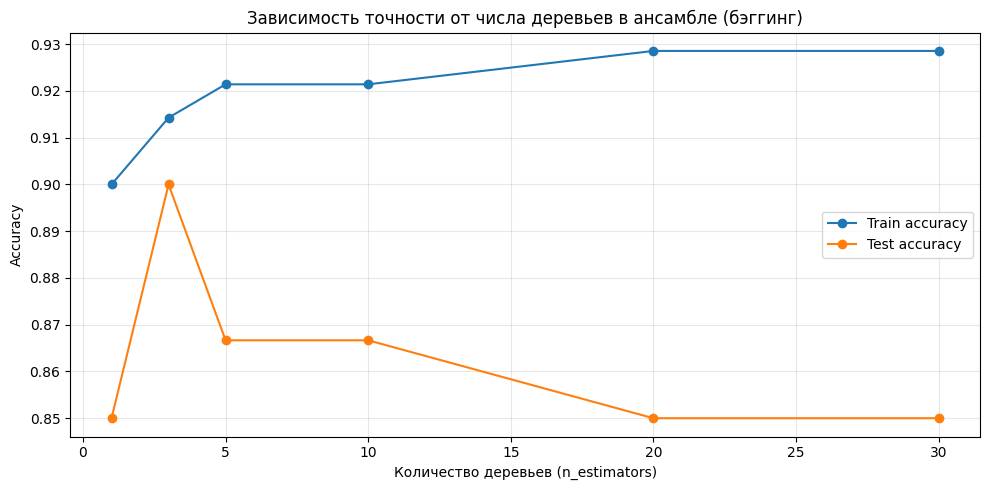

In [236]:
"""
Этап 2.6. График зависимости точности классификации от количества деревьев.

Визуализируем, как меняется train_accuracy и test_accuracy
при увеличении размера ансамбля.

График поможет увидеть:
    - рост устойчивости ансамбля;
    - есть ли переобучение;
    - какую пользу дает увеличение числа деревьев.
"""

plt.figure(figsize=(10, 5))

plt.plot(
    results_df_ensemble["n_estimators"],
    results_df_ensemble["train_accuracy"],
    marker="o",
    linestyle="-",
    label="Train accuracy",
)

plt.plot(
    results_df_ensemble["n_estimators"],
    results_df_ensemble["test_accuracy"],
    marker="o",
    linestyle="-",
    label="Test accuracy",
)

plt.title("Зависимость точности от числа деревьев в ансамбле (бэггинг)")
plt.xlabel("Количество деревьев (n_estimators)")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### 2.7. Анализ зависимости точности от числа деревьев в ансамбле

На графике видно, как меняется качество классификации на обучающей и тестовой выборках при увеличении числа деревьев:

1. **Для небольших ансамблей (3 - 5 деревьев)**
   наблюдается рост точности на тестовой выборке.
   Таким образом, несколько деревьев уменьшают дисперсию модели, сглаживают случайность отдельных разбиений и дают более устойчивое решение.

2. **После 5 – 10 деревьев**
   точность на тесте перестает расти и стабилизируется.
   Это происходит по причине того, что набор моделей становится более однородным, дальнейшее увеличение числа деревьев уже не дает выигрыша в качестве.

3. **Train accuracy растет плавно**,
   без резких скачков.

4. **Test accuracy остается на уровне 0.85 – 0.90**,
   что говорит о "шумности" данных, ансамбль уменьшает вариативность, но не может сделать модель идеальной.

5. **Вывод:**
   Ансамбль деревьев (бэггинг) действительно увеличивает устойчивость модели и обеспечивает более стабильную точность по сравнению с одиночным деревом.
   На этом наборе данных максимальную точность ансамбль показывает при 3 – 5 деревьях, затем качество стабилизируется.


### Этап 3. Кластеризация и понижение размерности (k-means + PCA):

1. Загружаем датасет Iris:
- берем данные из sklearn.datasets.load_iris;
- упаковываем их в pandas.DataFrame с именованными колонками.

2. Выполняем масштабирование признаков (z-score нормализация):
- вычитаем среднее из каждого признака;
- делим на стандартное отклонение;
- приводим все признаки к одному масштабу перед кластеризацией.

3. Реализуем собственный алгоритм k-means:
- инициализация центров кластеров случайным образом (random_state);
- назначение точек ближайшему центру;
- пересчет центров как среднего по точкам кластера;
- проверка условия остановки.

4. Реализация PCA для уменьшения размерности до 2 компонент:
- центрируем данные;
- вычисляем ковариационную матрицу;
- извлекаем собственные значения/векторы через numpy.linalg;
- сортируем компоненты по убыванию дисперсии;
- преобразуем данные в пространство двух главных компонент.

5. Визуализация:
- строим scatter-график точек после PCA;
- раскрашиваем точки по кластерам;
- отображаем центры кластеров на плоскости;
- подписываем оси и добавляем легенду.

6. Сравнение результатов:
- запускаем KMeans из sklearn на тех же данных;
- сопоставляем центры кластеров (учитывая, что порядок кластеров может отличаться);
- визуально сравниваем распределения кластеров.

7. Формулируем вывод:
- что удалось заметить в поведение k-means;
- чем отличается собственная реализация от sklearn;
- когда и почему алгоритм сходится или застревает;
- как PCA помогает визуализации многомерных данных.

In [237]:
"""
Этап 3.1. Загрузка и подготовка данных (Iris dataset).

Используем классический датасет Iris:
    - 150 наблюдений;
    - 4 числовых признака (длина/ширина чашелистика и лепестка);
    - 3 класса (виды Iris);

Модель k-means не использует целевые метки,
поэтому мы работаем только с матрицей признаков X.

Логика:
    1. Загружаем данные через sklearn.datasets.load_iris().
    2. Упаковываем их в pandas.DataFrame, чтобы удобно работать и анализировать.
    3. Оставляем только признаки, которые будут переданы в k-means.
"""

from sklearn.datasets import load_iris

# Загружаем датасет
iris = load_iris()

# Матрица признаков (150 x 4)
X = pd.DataFrame(iris.data, columns=iris.feature_names)

# Метки классов (для визуального сравнения)
y_true = iris.target

# Просмотр первых строк для контроля
X.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [238]:
"""
Этап 3.2. Масштабирование признаков (z-score нормализация).

Логика:
    Алгоритм k-means минимизирует сумму квадратов расстояний до центров кластеров.
    Если признаки имеют разные масштабы, то признаки с большим разбросом будут доминировать.

Поэтому приводим каждый признак к единому масштабу:
    X_scaled = (X - X.mean()) / X.std()

После преобразования ожидаем (важно для корректной работы k-means):
    - среднее каждого признака = 0,
    - стандартное отклонение = 1,
    - все признаки равноправны при расчете расстояний.
"""

# Преобразуем DataFrame в numpy-массив
X_values = X.values.astype(float)

# Выполняем стандартизацию
X_scaled = (X_values - X_values.mean(axis=0)) / X_values.std(axis=0)

# Упакуем обратно в DataFrame для удобства анализа
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [239]:
"""
Этап 3.3. Реализация алгоритма k-means: вспомогательные функции.

Логика:
    - реализуем евклидово расстояние;
    - функцию инициализации центров кластеров;
    - назначение точек ближайшим центрам;
    - пересчет центров кластеров.

Алгоритм k-means:
    1. Случайно выбираем k начальных центров.
    2. Повторяем:
       - Назначаем каждую точку ближайшему центру (step "assign").
       - Пересчитываем центры как среднее по точкам кластера (step "update").
       - Проверяем сходимость (смещение центров < tolerance).
"""


def euclidean_distance(a: np.ndarray, b: np.ndarray) -> float:
    """
    Вычисляет евклидово расстояние между двумя векторами.

    Параметры:
        a, b: np.ndarray
            Векторы одинаковой длины.

    Возвращает:
        float
            Евклидово расстояние ||a - b||_2.
    """
    diff = a - b
    return float(np.sqrt(np.sum(diff ** 2)))


def init_centroids(
        X: np.ndarray,
        n_clusters: int,
        random_state: int | None = None,
) -> np.ndarray:
    """
    Инициализирует центры кластеров, выбирая случайные точки из X.

    Параметры:
        X: np.ndarray, shape (n_samples, n_features)
            Матрица признаков.
        n_clusters: int
            Количество кластеров.
        random_state: int or None
            Seed для воспроизводимости.

    Возвращает:
        centroids: np.ndarray, shape (n_clusters, n_features)
            Начальные центры кластеров.
    """
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]

    # Выбираем случайные уникальные индексы
    indices = rng.choice(n_samples, size=n_clusters, replace=False)
    centroids = X[indices]

    return centroids


def assign_clusters(
        X: np.ndarray,
        centroids: np.ndarray,
) -> np.ndarray:
    """
    Назначает каждую точку ближайшему центру.

    Параметры:
        X: np.ndarray, shape (n_samples, n_features)
            Матрица признаков.
        centroids : np.ndarray, shape (n_clusters, n_features)
            Текущие центры кластеров.

    Возвращает:
        labels: np.ndarray, shape (n_samples,)
            Индекс ближайшего кластера для каждой точки.
    """
    # Считаем расстояния от всех точек до всех центров
    # Получаем матрицу shape (n_samples, n_clusters)
    distances = np.linalg.norm(
        X[:, np.newaxis, :] - centroids[np.newaxis, :, :],
        axis=2,
    )

    # Ближайший центр = индекс минимального расстояния по каждой строке
    labels = np.argmin(distances, axis=1)
    return labels


def update_centroids(
        X: np.ndarray,
        labels: np.ndarray,
        n_clusters: int,
        random_state: int | None = None,
) -> np.ndarray:
    """
    Пересчитывает центры кластеров как среднее по точкам, попавшим в кластер.

    Если какой-то кластер оказался пустым, центр переинициализируется
    случайной точкой из выборки, что предотвращает залипание пустых кластеров.

    Параметры:
        X: np.ndarray, shape (n_samples, n_features)
        labels: np.ndarray, shape (n_samples,)
            Номера кластеров для каждой точки.
        n_clusters: int
        random_state: int or None

    Возвращает:
        new_centroids: np.ndarray, shape (n_clusters, n_features)
    """
    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape

    new_centroids = np.zeros((n_clusters, n_features), dtype=float)

    for k in range(n_clusters):
        # Точки, отнесенные к кластеру k
        cluster_points = X[labels == k]

        if cluster_points.shape[0] == 0:
            # Кластер пустой —> переинициализируем центр случайной точкой
            random_idx = rng.integers(0, n_samples)
            new_centroids[k] = X[random_idx]
        else:
            # Среднее по всем точкам кластера
            new_centroids[k] = cluster_points.mean(axis=0)

    return new_centroids


In [240]:
"""
Этап 3.3. Реализация собственного k-means в виде класса KMeansCustom.

Класс поддерживает:
    - n_clusters —> количество кластеров;
    - max_iter —> максимальное число итераций;
    - tol —> допуск по смещению центров для остановки;
    - random_state —> для воспроизводимой инициализации центров.

Методы:
    - fit(X) —> обучает алгоритм, находит центры кластеров;
    - predict(X) —> назначает новые точки ближайшим центрам;
    - fit_predict(X) —> обучение + предсказание меток для X.
"""


class KMeansCustom:
    """
    Реализация алгоритма k-means.

    Параметры:
        n_clusters: int
            Количество кластеров.
        max_iter: int
            Максимальное число итераций алгоритма.
        tol: float
            Допуск по смещению центров для критерия сходимости.
        random_state: Optional[int]
            Seed для воспроизводимой инициализации центров.

    Атрибуты:
        cluster_centers_: np.ndarray, shape (n_clusters, n_features)
            Найденные центры кластеров.
        labels_: np.ndarray, shape (n_samples,)
            Метки кластеров для обучающей выборки.
        n_iter_: int
            Число фактически выполненных итераций.
        inertia_: float
            Сумма квадратов расстояний от точек до их центров (как в sklearn).
    """

    def __init__(
            self,
            n_clusters: int = 3,
            max_iter: int = 300,
            tol: float = 1e-4,
            random_state: Optional[int] = None,
    ) -> None:
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        self.cluster_centers_: Optional[np.ndarray] = None
        self.labels_: Optional[np.ndarray] = None
        self.n_iter_: int = 0
        self.inertia_: Optional[float] = None

    def _compute_inertia(
            self,
            X: np.ndarray,
            centroids: np.ndarray,
            labels: np.ndarray,
    ) -> float:
        """
        Вычисляет сумму квадратов расстояний от точек до соответствующих центров.

        Аналог inertia_ из sklearn.KMeans.
        """
        distances = np.linalg.norm(X - centroids[labels], axis=1) ** 2
        return float(np.sum(distances))

    def fit(self, X: np.ndarray) -> "KMeansCustom":
        """
        Запускает алгоритм k-means на данных X.

        Алгоритм:
            1. Инициализируем центры (случайным выбором точек).
            2. Повторяем до сходимости или max_iter:
               - Назначаем точки ближайшим центрам.
               - Пересчитываем центры.
               - Считаем максимальное смещение центров.
               - Если смещение < tol —> останавливаемся.
        """
        X = np.asarray(X, dtype=float)

        # 1. Инициализация центров
        centroids = init_centroids(
            X,
            n_clusters=self.n_clusters,
            random_state=self.random_state,
        )

        for iteration in range(self.max_iter):
            # 2. Назначаем каждую точку ближайшему центру
            labels = assign_clusters(X, centroids)

            # 3. Пересчитываем центры
            new_centroids = update_centroids(
                X,
                labels,
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )

            # 4. Оцениваем смещение центров
            shift = np.linalg.norm(new_centroids - centroids, axis=1).max()

            centroids = new_centroids
            self.n_iter_ = iteration + 1

            # 5. Проверяем критерий остановки
            if shift < self.tol:
                break

        # Сохраняем результаты
        self.cluster_centers_ = centroids
        self.labels_ = assign_clusters(X, centroids)
        self.inertia_ = self._compute_inertia(X, centroids, self.labels_)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Назначает точки X ближайшим кластерам.

        Можно использовать после fit() для новых данных.
        """
        if self.cluster_centers_ is None:
            raise RuntimeError("Модель еще не обучена. Сначала вызовите fit().")

        X = np.asarray(X, dtype=float)
        labels = assign_clusters(X, self.cluster_centers_)
        return labels

    def fit_predict(self, X: np.ndarray) -> np.ndarray:
        """
        Комбинированный метод: обучение + предсказание меток для X.
        """
        return self.fit(X).labels_


In [241]:
"""
Этап 3.3. Запуск k-means: сравнение собственной реализации и sklearn.KMeans.

Логика:
    1. Обучаем собственную реализацию KMeansCustom на масштабированных данных X_scaled.
    2. Обучаем KMeans из sklearn на тех же данных.
    3. Сравниваем:
       - инерцию (сумму квадратов расстояний до центров),
       - количество итераций до сходимости,
       - визуально и далее через PCA.

Примечание:
    Кластеризация —> задача без учителя, поэтому номера кластеров (0, 1, 2)
    могут отличаться между реализациями.
"""

from sklearn.cluster import KMeans

# Преобразуем масштабированные данные в numpy-массив
X_scaled_values = X_scaled_df.values

# Количество кластеров для Iris (3 вида)
N_CLUSTERS = 3

# 1. Собственная реализация k-means
kmeans_custom = KMeansCustom(
    n_clusters=N_CLUSTERS,
    max_iter=300,
    tol=1e-4,
    random_state=42,
)

labels_custom = kmeans_custom.fit_predict(X_scaled_values)

# 2. Реализация из sklearn
kmeans_sklearn = KMeans(
    n_clusters=N_CLUSTERS,
    # стандартный параметр: несколько запусков с разной инициализацией
    n_init=10,
    max_iter=300,
    tol=1e-4,
    random_state=42,
)

labels_sklearn = kmeans_sklearn.fit_predict(X_scaled_values)

# 3. Сводная таблица с базовыми метриками
comparison_df = pd.DataFrame(
    {
        "model": ["KMeansCustom", "sklearn.KMeans"],
        "inertia": [kmeans_custom.inertia_, kmeans_sklearn.inertia_],
        "n_iter": [kmeans_custom.n_iter_, kmeans_sklearn.n_iter_],
    }
)

comparison_df


,model,inertia,n_iter
0,KMeansCustom,140.901532,5
1,sklearn.KMeans,139.820496,4


In [242]:
"""
Этап 3.4. Реализация PCA (Principal Component Analysis).

Цель:
    Уменьшить размерность данных Iris (4 признака) до 2 главных компонент.
    Это необходимо для:
        - визуализации результата кластеризации на плоскости;
        - сохранения максимально исходной дисперсии.

Логика:
    1. Центрируем данные: вычитаем средние по каждому признаку.
    2. Строим ковариационную матрицу признаков.
    3. Находим собственные значения и собственные векторы ковариационной матрицы.
    4. Сортируем их по убыванию собственных значений (дисперсии).
    5. Берем первые k компонент (k=2).
    6. Проецируем исходные данные на найденные компоненты.
"""


class PCACustom:
    """
    Реализация PCA.

    Параметры:
        n_components: int
            Число главных компонент, на которое нужно уменьшить размерность.

    Атрибуты:
        components_: np.ndarray, shape (n_components, n_features)
            Матрица главных компонент (ортонормированные векторы).
        explained_variance_: np.ndarray, shape (n_components,)
            Собственные значения (объясненная дисперсия по компонентам).
        explained_variance_ratio_: np.ndarray, shape (n_components,)
            Доля общей дисперсии, объясненная каждой компонентой.
        mean_: np.ndarray, shape (n_features,)
            Вектор средних значений признаков (для центрирования).
    """

    def __init__(self, n_components: int = 2) -> None:
        self.n_components = n_components

        self.components_: Optional[np.ndarray] = None
        self.explained_variance_: Optional[np.ndarray] = None
        self.explained_variance_ratio_: Optional[np.ndarray] = None
        self.mean_: Optional[np.ndarray] = None

    def fit(self, X: np.ndarray) -> "PCACustom":
        """
        Обучает PCA на данных X: находит главные компоненты.

        Параметры:
            X: np.ndarray, shape (n_samples, n_features)
                Матрица признаков.

        Возвращает:
            self: PCACustom
        """
        X = np.asarray(X, dtype=float)

        # 1. Центрируем данные
        self.mean_ = X.mean(axis=0)
        X_centered = X - self.mean_

        # 2. Ковариационная матрица (features × features)
        # Используем деление на n_samples - 1
        n_samples = X.shape[0]
        cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)

        # 3. Собственные значения и собственные векторы
        # Для симметричной ковариационной матрицы используем eigh
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # 4. Сортируем по убыванию дисперсии (eigenvalues)
        sorted_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues_sorted = eigenvalues[sorted_idx]
        eigenvectors_sorted = eigenvectors[:, sorted_idx]

        # 5. Оставляем только первые n_components
        self.explained_variance_ = eigenvalues_sorted[: self.n_components]
        total_variance = eigenvalues_sorted.sum()
        self.explained_variance_ratio_ = self.explained_variance_ / total_variance

        # Компоненты: каждая строка —> главный компонент
        self.components_ = eigenvectors_sorted[:, : self.n_components].T

        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Преобразует данные X в пространство главных компонент.

        Параметры:
            X: np.ndarray, shape (n_samples, n_features)

        Возвращает:
            X_pca: np.ndarray, shape (n_samples, n_components)
        """
        if self.components_ is None or self.mean_ is None:
            raise RuntimeError("PCA еще не обучен. Сначала вызовите fit().")

        X = np.asarray(X, dtype=float)
        X_centered = X - self.mean_
        X_pca = X_centered @ self.components_.T
        return X_pca

    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        """
        Комбинированный метод: fit + transform.
        Если PCA используется только на одном наборе данных.
        """
        return self.fit(X).transform(X)


In [243]:
"""
Этап 3.4. Применение PCACustom к данным Iris.

Цель - снизить размерность:
    - было: 4 признака (sepal length/width, petal length/width);
    - стало: 2 главные компоненты (PC1, PC2).
"""

# Используем нашу реализацию PCA
pca = PCACustom(n_components=2)

X_pca_2d = pca.fit_transform(X_scaled_values)

X_pca_df = pd.DataFrame(
    X_pca_2d,
    columns=["PC1", "PC2"],
)

X_pca_df.head()

,PC1,PC2
0,2.264703,0.480027
1,2.080961,-0.674134
2,2.364229,-0.341908
3,2.299384,-0.597395
4,2.389842,0.646835


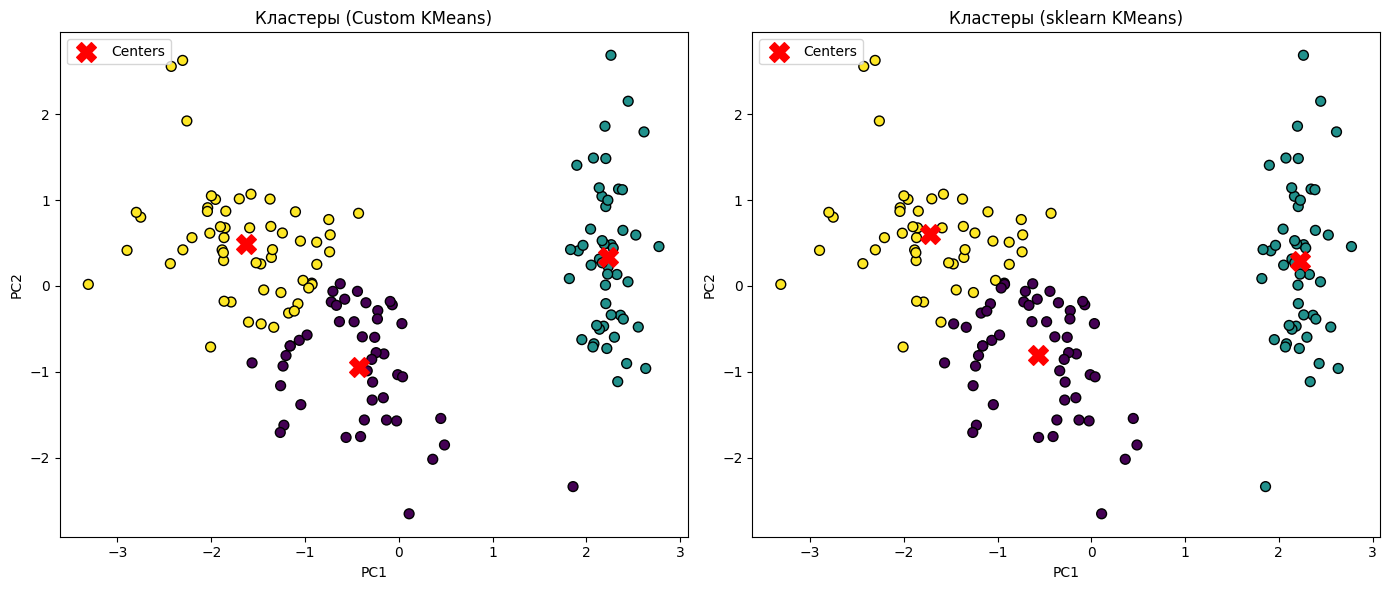

In [244]:
"""
Этап 3.5. Визуализация кластеров в 2D-пространстве после PCA.

Рисуем:
    - точки данных (PC1, PC2);
    - раскрашиваем по кластерам;
    - добавляем центры кластеров, также преобразованные PCA;
    - строим два соседних графика: Custom KMeans и sklearn KMeans.

Цель визуализации: сравнить форму и расположение групп.
"""

# Получаем центры кластеров
centers_custom = kmeans_custom.cluster_centers_
centers_sklearn = kmeans_sklearn.cluster_centers_

# Проецируем центры в пространство PCA
centers_custom_pca = pca.transform(centers_custom)
centers_sklearn_pca = pca.transform(centers_sklearn)

# Рисуем два графика
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Custom KMeans
axes[0].scatter(
    X_pca_df["PC1"],
    X_pca_df["PC2"],
    c=labels_custom,
    s=50,
    cmap="viridis",
    edgecolor="k",
)
axes[0].scatter(
    centers_custom_pca[:, 0],
    centers_custom_pca[:, 1],
    c="red",
    s=200,
    marker="X",
    label="Centers",
)
axes[0].set_title("Кластеры (Custom KMeans)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend()

# 2. sklearn KMeans
axes[1].scatter(
    X_pca_df["PC1"],
    X_pca_df["PC2"],
    c=labels_sklearn,
    s=50,
    cmap="viridis",
    edgecolor="k",
)
axes[1].scatter(
    centers_sklearn_pca[:, 0],
    centers_sklearn_pca[:, 1],
    c="red",
    s=200,
    marker="X",
    label="Centers",
)
axes[1].set_title("Кластеры (sklearn KMeans)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].legend()

plt.tight_layout()
plt.show()

In [245]:
"""
Этап 3.6. Сопоставление центров кластеров между KMeansCustom и sklearn.KMeans.

Цель:
    Порядок кластеров в k-means не фиксирован,
    поэтомусобственный алгоритм может назвать кластером 0 то,
    что у sklearn является кластером 2, и наоборот.
    Чтобы корректно сравнивать центры, нужно сопоставить их по расстоянию,
    а не по индексу.

Алгоритм:
    1. Строим матрицу попарных расстояний между центрами:
       - строки —> центры KMeansCustom,
       - столбцы —> центры sklearn.KMeans.
    2. Перебираем все возможные соответствия (перестановки индексов кластеров)
       и выбираем то, которое дает минимальную суммарную дистанцию.
"""

import itertools

# shape: (3, 4)
centers_custom = kmeans_custom.cluster_centers_
# shape: (3, 4)
centers_sklearn = kmeans_sklearn.cluster_centers_

# 1. Матрица попарных расстояний между центрами (в пространстве масштабированных признаков)
distance_matrix = np.linalg.norm(
    centers_custom[:, np.newaxis, :] - centers_sklearn[np.newaxis, :, :],
    axis=2,
)

distance_matrix_df = pd.DataFrame(
    distance_matrix,
    columns=[f"sk_center_{j}" for j in range(N_CLUSTERS)],
    index=[f"custom_center_{i}" for i in range(N_CLUSTERS)],
)

display(distance_matrix_df)

# 2. Ищем оптимальное соответствие центров по суммарной дистанции
best_perm = None
best_total_distance = np.inf

indices = range(N_CLUSTERS)

for perm in itertools.permutations(indices):
    # perm[j] = индекс sklearn-кластера, который ставим в соответствие custom-кластеру j
    total_dist = sum(distance_matrix[j, perm[j]] for j in indices)
    if total_dist < best_total_distance:
        best_total_distance = total_dist
        best_perm = perm

# Результат в виде таблицы
matching_rows = []
for custom_idx, sklearn_idx in enumerate(best_perm):
    matching_rows.append(
        {
            "custom_cluster": custom_idx,
            "sklearn_cluster": sklearn_idx,
            "distance_between_centers": distance_matrix[custom_idx, sklearn_idx],
        }
    )

centers_matching_df = pd.DataFrame(matching_rows)
centers_matching_df

,sk_center_0,sk_center_1,sk_center_2
custom_center_0,0.202294,2.923142,2.019556
custom_center_1,3.033007,0.054501,3.961963
custom_center_2,1.672868,3.863985,0.148437


,custom_cluster,sklearn_cluster,distance_between_centers
0,0,0,0.202294
1,1,1,0.054501
2,2,2,0.148437


### 3.6. Сравнение результатов кластеризации (центры кластеров)

Матрица попарных расстояний между центрами кластеров показывает, что для каждого
кластера, найденного собственной реализацией KMeans, существует очень близкий центр
в sklearn.KMeans. Минимальные расстояния малы по сравнению с разбросом данных.

После полного перебора всех перестановок порядка кластеров получено соответствие:
```
custom_cluster 0 -> sklearn_cluster 0,
custom_cluster 1 -> sklearn_cluster 1,
custom_cluster 2 -> sklearn_cluster 2.
```
Это означает, что обе реализации восстанавливают одну и ту же структуру кластеров.

### 3.7. Выводы по алгоритму k-means и PCA

**1. Поведение k-means**

- Алгоритм быстро сходится на данных Iris (4–5 итераций).
- При случайной инициализации возможны небольшие отличия, но структура кластеров остается стабильной.
- Алгоритм стремится минимизировать сумму квадратов расстояний до центров и всегда сходится,
  но иногда к локальному минимуму.

**2. Отличия собственной реализации от sklearn.KMeans**

- Собственная версия использует простую случайную инициализацию.
- sklearn применяет k-means++ и многократные перезапуски (`n_init`), что уменьшает вероятность плохих стартов.
- Найденные кластеры и центры практически совпадают.

**3. Почему алгоритм может застревать**

- Если центры выбраны неудачно, алгоритм может сойтись к субоптимальному решению.
- На Iris этого почти не происходит, потому что кластеры хорошо разделимы после масштабирования.

**4. Как PCA помогает анализу кластеров**

- PCA преобразует 4-х мерные данные в 2D, сохраняя максимальную дисперсию.
- Проекции на PC1 и PC2 позволяют визуально увидеть три четкие группы,
  совпадающие для обеих реализаций.
- В пространстве PCA хорошо видны различия между видами ирисов и положение центров,
  что невозможно увидеть напрямую в исходном 4D-пространстве.

**Итог:**
Собственная реализация k-means корректна, результаты совпадают со sklearn как численно,
так и визуально. PCA существенно облегчает интерпретацию кластеров и делает
качество работы алгоритма наглядным.

# 4. Итоги проекта

В ходе проекта были вручную реализованы и исследованы три алгоритма:
- дерево решений;
- ансамбль деревьев (бэггинг);
- кластеризация k-means;
- метод снижения размерности PCA.

## Общие принципы и сходства алгоритмов
- Все три алгоритма основаны на идее разделения данных по некоторым критериям:
  дерево решений делит пространство признаков на области, ансамбль усредняет
  несколько таких разбиений, а k-means группирует объекты по близости центрам.
- Во всех методах важную роль играет выбор параметров и критериев остановки:
  глубина дерева влияет на переобучение, количество деревьев на устойчивость,
  число кластеров на форму группировки, в k-means и PCA масштабирование.

## Влияние параметров
- Более глубокие деревья дают точное разбиение обучающих данных,
  но хуже обобщают результаты (переобучение).
- Увеличение числа деревьев в бэггинге уменьшает вариативность предсказаний
  и делает модель устойчивее при небольшом изменении данных.
- В k-means число кластеров определяет структуру группировки:
  выбор k=3 для Iris оказался естественным и хорошо отражает природу данных.
- Масштабирование признаков критично для корректной работы k-means,
  а PCA помогает визуально интерпретировать многомерную структуру данных.

## Проблемы при реализации
- Реализация дерева решений потребовала аккуратного расчета критериев Джини/энтропии.
- В k-means сложность была связана с обработкой пустых кластеров
  и обеспечением устойчивой сходимости.
- Для воспроизводимости ансамблей использовалось фиксирование `random_state`
  для каждой bootstrap-выборки.
- Реализация PCA потребовала правильного вычисления ковариационной матрицы
  и сортировки собственных векторов по убыванию дисперсии.

## Проверка корректности и воспроизводимость
- Для всех алгоритмов результаты сравнивались со стандартными реализациями sklearn.
- Использование фиксированных `random_state` обеспечило идентичность повторных запусков.
- Визуализация решений дерева, границ классификации, структуры кластеров после PCA
  позволила убедиться в корректности поведения моделей.
- Численные метрики (inertia, accuracy) подтвердили, что ручные реализации
  дают результаты схожие с sklearn.